[View in Colaboratory](https://colab.research.google.com/github/BUPT/awesome-chatbot/blob/master/CAIC_9_demo_of_VAE_Auto_Poem.ipynb)

# CAIC #9 - Example of VAE : Auto-Poem

### Reference:
- https://github.com/bojone/vae
- https://kexue.fm/archives/5253

### Author: [824zzy](https://github.com/824zzy)

## DEMO: Auto-Poem


In [9]:
!apt-get install graphviz
!pip install pydot graphviz easydict

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fontconfig libann0 libcairo2 libcdt5 libcgraph6 libdatrie1 libgd3
  libgts-0.7-5 libgts-bin libgvc6 libgvpr2 libjbig0 liblab-gamut1 libltdl7
  libpango-1.0-0 libpangocairo-1.0-0 libpangoft2-1.0-0 libpathplan4
  libpixman-1-0 libthai-data libthai0 libtiff5 libwebp6 libxaw7 libxcb-render0
  libxcb-shm0 libxmu6 libxpm4 libxt6
Suggested packages:
  gsfonts graphviz-doc libgd-tools
The following NEW packages will be installed:
  fontconfig graphviz libann0 libcairo2 libcdt5 libcgraph6 libdatrie1 libgd3
  libgts-0.7-5 libgts-bin libgvc6 libgvpr2 libjbig0 liblab-gamut1 libltdl7
  libpango-1.0-0 libpangocairo-1.0-0 libpangoft2-1.0-0 libpathplan4
  libpixman-1-0 libthai-data libthai0 libtiff5 libwebp6 libxaw7 libxcb-render0
  libxcb-shm0 libxmu6 libxpm4 libxt6
0 upgraded, 30 newly installed, 0 to remove and 12 not upgraded.
Need to get 4,154 kB o

In [2]:
#! -*- coding:utf-8 -*-
import re
import codecs
import numpy as np
from keras.layers import *
from keras.models import Model
from keras import backend as K
from keras.engine.topology import Layer
from keras.callbacks import Callback
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


### 数据预处理：文本数据使用的是全唐诗
[全唐诗下载地址](https://github.com/824zzy/blogResources/blob/master/txtRestources/poems.txt)

In [3]:
!wget https://github.com/824zzy/blogResources/blob/master/txtRestources/poems.txt

--2018-10-23 08:51:51--  https://github.com/824zzy/blogResources/blob/master/txtRestources/poems.txt
Resolving github.com (github.com)... 192.30.253.112, 192.30.253.113
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘poems.txt.1’

poems.txt.1             [ <=>                ]  40.55K  --.-KB/s    in 0.02s   

2018-10-23 08:51:52 (1.61 MB/s) - ‘poems.txt.1’ saved [41522]



In [3]:
n = 5 # 只选择五言诗
latent_dim = 64 # 隐变量维度
hidden_dim = 64 # 隐变量节点数

s = codecs.open('poems.txt', encoding='utf-8').read()
s = re.findall(u'　　(.{%s}，.{%s}。.*?)\r\n'%(n,n), s) # 通过正则表达式找出五言诗
poem = []
for i in s:
    for j in i.split(u'。'): # 按句切分
        if j:
            poem.append(j)

poem = [i[:n] + i[n+1:] for i in poem if len(i) == 2*n+1] # 去除逗号

id2char = dict(enumerate(set(''.join(poem)))) #
print('将id映射到字:\n', id2char)
char2id = {j:i for i,j in id2char.items()}
print('将字映射到id:\n', char2id)
print(len(char2id))
poem2id = [[char2id[j] for j in i] for i in poem]
poem2id = np.array(poem2id)
print("将唐诗映射到id:\n", poem2id)

将id映射到字:
 {0: '鞦', 1: '妄', 2: '藜', 3: '渑', 4: '笛', 5: '翛', 6: '哮', 7: '造', 8: '决', 9: '荪', 10: '斐', 11: '闠', 12: '狗', 13: '佺', 14: '颔', 15: '胡', 16: '广', 17: '藿', 18: '算', 19: '深', 20: '蛸', 21: '溱', 22: '奥', 23: '麟', 24: '栏', 25: '墀', 26: '仙', 27: '剽', 28: '纱', 29: '汪', 30: '钉', 31: '猬', 32: '桡', 33: '陌', 34: '尹', 35: '窍', 36: '佗', 37: '絮', 38: '高', 39: '赩', 40: '纡', 41: '抛', 42: '覆', 43: '嘹', 44: '录', 45: '崭', 46: '余', 47: '筲', 48: '癸', 49: '宥', 50: '疠', 51: '孤', 52: '贻', 53: '美', 54: '叔', 55: '聆', 56: '菼', 57: '旍', 58: '燀', 59: '访', 60: '吴', 61: '恙', 62: '玕', 63: '缝', 64: '佩', 65: '闺', 66: '艮', 67: '狎', 68: '恩', 69: '栊', 70: '翥', 71: '娥', 72: '营', 73: '廛', 74: '旱', 75: '则', 76: '貂', 77: '衮', 78: '暵', 79: '产', 80: '澜', 81: '迸', 82: '儗', 83: '先', 84: '揄', 85: '堠', 86: '惬', 87: '揣', 88: '戺', 89: '潞', 90: '魂', 91: '阔', 92: '糅', 93: '假', 94: '聪', 95: '班', 96: '导', 97: '渺', 98: '沄', 99: '帟', 100: '婺', 101: '佳', 102: '蜍', 103: '姮', 104: '诒', 105: '婷', 106: '惜', 107: '士', 108: '恒', 109: '赁',

### Gated Convolutional Neural Network
GCNN作为模型的一部分，起到处理文本数据的作用。

In [0]:
class GCNN(Layer): # GCNN with residual
    def __init__(self, output_dim=None, residual=False, **kwargs):
        super(GCNN, self).__init__(**kwargs)
        self.output_dim = output_dim
        self.residual = residual
    def build(self, input_shape):
        if self.output_dim == None:
            self.output_dim = input_shape[-1]
        self.kernel = self.add_weight(name='gcnn_kernel',
                                      shape=(3, input_shape[-1],
                                             self.output_dim * 2),
                                      initializer='glorot_uniform',
                                      trainable=True)
    def call(self, x):
        _ = K.conv1d(x, self.kernel, padding='same')
        _ = _[:, :, :self.output_dim] * K.sigmoid(_[:, :, self.output_dim:])
        if self.residual:
            return _ + x
        else:
            return _

### 模型主体结构

In [5]:
input_sentence = Input(shape=(2*n,), dtype='int32')
input_vec = Embedding(len(char2id), hidden_dim)(input_sentence) # id转向量
h = GCNN(residual=True)(input_vec) # GCNN层
h = GCNN(residual=True)(h) # GCNN层
h = GlobalAveragePooling1D()(h) # 池化

# 算均值方差
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0, stddev=1)
    return z_mean + K.exp(z_log_var / 2) * epsilon

z = Lambda(sampling)([z_mean, z_log_var])

# 定义解码层，分开定义是为了后面的重用
decoder_hidden = Dense(hidden_dim*(2*n))
decoder_cnn = GCNN(residual=True)
decoder_dense = Dense(len(char2id), activation='softmax')

h = decoder_hidden(z)
h = Reshape((2*n, hidden_dim))(h)
h = decoder_cnn(h)
output = decoder_dense(h)

# 建立模型
vae = Model(input_sentence, output)

# xent_loss是重构loss，kl_loss是KL loss
xent_loss = K.sum(K.sparse_categorical_crossentropy(input_sentence, output), 1)
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)

# add_loss是新增的方法，用于更灵活地添加各种loss
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()
# 重用解码层，构建单独的生成模型
decoder_input = Input(shape=(latent_dim,))
_ = decoder_hidden(decoder_input)
_ = Reshape((2*n, hidden_dim))(_)
_ = decoder_cnn(_)
_output = decoder_dense(_)
generator = Model(decoder_input, _output)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 10)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 10, 64)       312704      input_1[0][0]                    
__________________________________________________________________________________________________
gcnn_1 (GCNN)                   (None, 10, 64)       24576       embedding_1[0][0]                
__________________________________________________________________________________________________
gcnn_2 (GCNN)                   (None, 10, 64)       24576       gcnn_1[0][0]                     
__________________________________________________________________________________________________
global_ave

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: Output "dense_4" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "dense_4" during training.


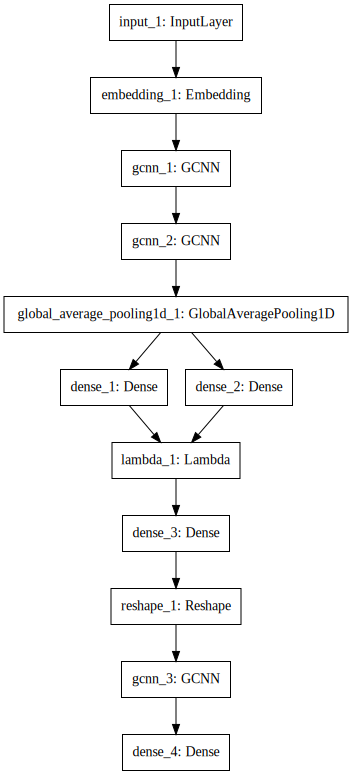

In [6]:
SVG(model_to_dot(vae).create(prog='dot', format='svg'))

### 生成五言诗

In [0]:
# 利用生成模型随机生成一首诗
def gen():
    r = generator.predict(np.random.randn(1, latent_dim))[0]
    r = r.argmax(axis=1)
    return ''.join([id2char[i] for i in r[:n]])\
           + u'，'\
           + ''.join([id2char[i] for i in r[n:]])


# 回调器，方便在训练过程中输出
class Evaluate(Callback):
    def __init__(self):
        self.log = []
    def on_epoch_end(self, epoch, logs=None):
        self.log.append(gen())
        print (u'          %s'%(self.log[-1]))


evaluator = Evaluate()

vae.fit(poem2id,
        shuffle=True,
        epochs=100,
        batch_size=64,
        callbacks=[evaluator])

vae.save_weights('shi.model')

for i in range(20):
    print(gen())

Epoch 1/100
30003/30003 [==============================] - 190s 6ms/step - loss: 74.0122
          不山不山子，不人云山山
Epoch 2/100
 2048/30003 [=>............................] - ETA: 2:56 - loss: 70.5928